In [9]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
from OptimumFilter import *
from trace_IO import *
import glob

In [16]:
import os
import glob
import numpy as np

# Define the sampling frequency for your data
sampling_frequency = 3906250  # Hz

# Path to channel template traces and noise PSD
channel_traces_directory = "../wk9/sum/individual_vac_1800/"
noise_psd = np.load("../../templates/noise_psd_from_MMC.npy")

# Load normalized template traces per channel
channel_trace_files = glob.glob(os.path.join(channel_traces_directory, "channel_*_normalized_trace.npy"))

# Initialize Optimum Filters
channel_optimum_filters = {}
print("\n--- Creating Channel-wise Optimum Filters ---")
for file_path in sorted(channel_trace_files):  # Sorted for consistent channel order
    file_name = os.path.basename(file_path)
    channel_number = int(file_name.split('_')[1])
    
    # Load this channel’s template trace
    channel_template = np.load(file_path)
    
    # Initialize the Optimum Filter instance
    of = OptimumFilter(channel_template, noise_psd, sampling_frequency)
    
    # Store in dictionary
    channel_optimum_filters[channel_number] = of

# Sanity check: make sure all required channels are loaded
expected_channels = set(range(45, 54))
loaded_channels = set(channel_optimum_filters.keys())
missing = expected_channels - loaded_channels
if missing:
    raise ValueError(f"Missing template trace(s) for channel(s): {sorted(missing)}")

print(f"✓ Initialized optimum filters for channels: {sorted(channel_optimum_filters.keys())}")




--- Creating Channel-wise Optimum Filters ---
✓ Initialized optimum filters for channels: [45, 46, 47, 48, 49, 50, 51, 52, 53]


Processing files:   0%|          | 0/32 [00:00<?, ?it/s]

Processing files: 100%|██████████| 32/32 [01:02<00:00,  1.97s/it]


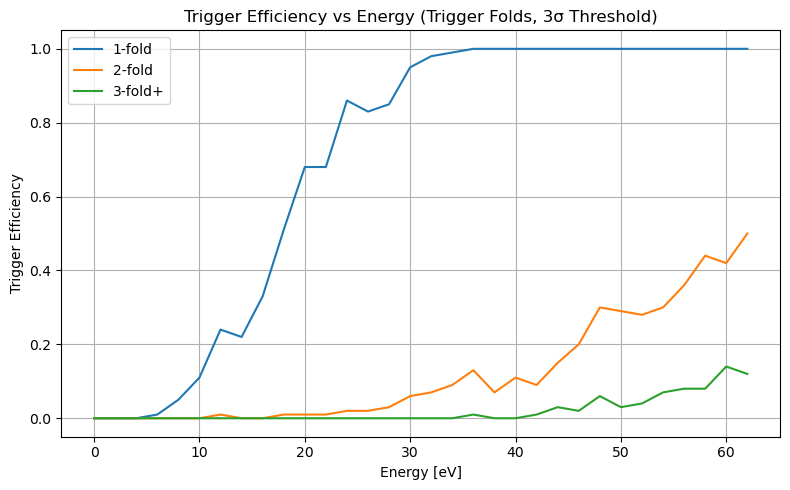

In [18]:


# Define thresholds using vacuum std values from quantized noise
channel_std = {
    45: 0.8440, 46: 0.7196, 47: 0.7514, 48: 0.7595, 49: 0.7367,
    50: 0.8430, 51: 0.6612, 52: 0.7112, 53: 0.6817,
}
threshold_3sigma = {ch: 3 * sigma for ch, sigma in channel_std.items()}

# Path to QP sample files
base_path = Path("/ceph/dwong/trigger_samples/qp_sample")
file_paths = sorted(base_path.glob("QP_sample_quantized_*eV.zst"))

# Extract energy from filenames
def extract_energy(fp):
    match = re.search(r'_(\d+)eV', fp.stem)
    return int(match.group(1)) if match else -1

file_paths = sorted(file_paths, key=extract_energy)
energies = [extract_energy(fp) for fp in file_paths]

# Store results for 1-fold, 2-fold, 3-fold triggering
fold_results = {
    "1-fold": [0.0] * len(file_paths),
    "2-fold": [0.0] * len(file_paths),
    "3-fold+": [0.0] * len(file_paths),
}

# Worker function to process one file
def process_file(index, energy, path):
    quantized_traces = load_traces_from_zstd(str(path), n_traces=100)  # shape (100, 54, 32768)
    fold_counts = {"1-fold": 0, "2-fold": 0, "3-fold+": 0}

    for trace_set in quantized_traces:
        trigger_count = 0
        for ch in range(45, 54):
            amp, _ = channel_optimum_filters[ch].fit(trace_set[ch])
            if amp > threshold_3sigma[ch]:
                trigger_count += 1

        if trigger_count == 1:
            fold_counts["1-fold"] += 1
        elif trigger_count == 2:
            fold_counts["2-fold"] += 1
            fold_counts["1-fold"] += 1
        elif trigger_count >= 3:
            fold_counts["3-fold+"] += 1
            fold_counts["2-fold"] += 1
            fold_counts["1-fold"] += 1

    total = len(quantized_traces)
    return index, {k: v / total for k, v in fold_counts.items()}

# Run in parallel with max 10 threads and track progress
with ThreadPoolExecutor(max_workers=10) as executor:
    futures = [executor.submit(process_file, i, e, p) for i, (e, p) in enumerate(zip(energies, file_paths))]
    for future in tqdm(as_completed(futures), total=len(futures), desc="Processing files"):
        idx, result = future.result()
        for fold_type in result:
            fold_results[fold_type][idx] = result[fold_type]

# Plot efficiency curves
plt.figure(figsize=(8, 5))
for fold_type in ["1-fold", "2-fold", "3-fold+"]:
    plt.plot(energies, fold_results[fold_type], label=fold_type)
plt.xlabel("Energy [eV]")
plt.ylabel("Trigger Efficiency")
plt.title("Trigger Efficiency vs Energy (Trigger Folds, 3σ Threshold)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [27]:
import yaml
import numpy as np
import zstandard as zstd
import os
from TraceSimulator import LongTraceSimulator

def read_yaml_to_dict(file_path):
    with open(file_path, 'r') as file:
        config_dict = yaml.safe_load(file)
    return config_dict

config = read_yaml_to_dict('/home/dwong/DELight_mtr/trigger_study/wk10/config.yaml')
lts = LongTraceSimulator(config)


In [30]:
trace, idx= lts.generate(
            E=1000,
            x=0, y=0, z=-1800,
            no_noise=False,
            type_recoil='NR',
            quantize=True,
            phonon_only=False
        )

In [29]:
trace.shape

(1, 54, 32768)

In [26]:
idx

array([[1881144, 1201437, 3107613, 2262213, 2356125, 1622398, 1726656,
         770928, 1538970,  177303,  985264, 2080463, 1663529, 1729253,
        1854830, 2107652, 1404290, 2279009,  650690, 2634656, 2446409,
        3167093,   97506,  276232,  961052, 1183011, 1884122, 2389251,
        2197543,  924677,  712845, 2690581,  525391,  495596,  194544,
        1944940,  200499,  313068, 1830807, 1351258, 2657055, 1186348,
         422998,  313234, 1313523,  868504, 2457128, 1996830,  380263,
        1091333, 2851415, 2103554, 2069219, 2687936]])